<a href="https://colab.research.google.com/github/Jiddarh/python-repo/blob/main/SCD_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

# Replace with actual path
base_path = '/content/drive/MyDrive/SCD_Datasets/archive'

# List subfolders
for folder in os.listdir(base_path):
  print(folder)

Positive
Negative


In [7]:
import os, shutil
import random

# Paths
original_dataset_dir = '/content/drive/MyDrive/SCD_Dataset/archive'
base_dir = '/content/drive/MyDrive/SCD_Dataset/cleaned_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create folders
for category in ['train', 'val']:
    for label in ['positive', 'negative']:
        os.makedirs(os.path.join(base_dir, category, label), exist_ok=True)

# Helper function to copy images
def split_data(src, dst_train, dst_val, split_ratio=0.8):
    images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)

    for i, img in enumerate(images):
        src_path = os.path.join(src, img)
        dst_path = os.path.join(dst_train if i < split_point else dst_val, img)
        shutil.copyfile(src_path, dst_path)

# Set source folders
positive_dir = os.path.join(original_dataset_dir, 'Positive', 'Labelled')
negative_dir = os.path.join(original_dataset_dir, 'Negative', 'Clear')

# Split and copy
split_data(positive_dir, os.path.join(train_dir, 'positive'), os.path.join(val_dir, 'positive'))
split_data(negative_dir, os.path.join(train_dir, 'negative'), os.path.join(val_dir, 'negative'))

print(" Dataset split into training and validation folders.")

 Dataset split into training and validation folders.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf
import os

# Set dataset root directory (no need for train/val subfolders if using split)
dataset_dir = "/content/drive/MyDrive/SCD_Dataset/archive"  # Make sure this is correct

img_size = (150, 150)
batch_size = 32

# Define ImageDataGenerator with 20% validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Use 'subset' argument to split the single folder into training and validation
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 794 images belonging to 2 classes.
Found 197 images belonging to 2 classes.


In [11]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with the specified metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7208 - auc: 0.4925 - loss: 0.5877 - precision: 0.7971 - recall: 0.8370

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.7248 - auc: 0.4938 - loss: 0.5829 - precision: 0.7993 - recall: 0.8418 - val_accuracy: 0.7083 - val_auc: 0.7216 - val_loss: 0.8758 - val_precision: 0.7083 - val_recall: 1.0000
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8438 - auc: 0.5444 - loss: 0.5173 - precision: 0.8438 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8438 - auc: 0.5444 - loss: 0.5173 - precision: 0.8438 - recall: 1.0000 - val_accuracy: 0.7500 - val_auc: 0.7300 - val_loss: 0.7034 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8596 - auc: 0.5449 - loss: 0.4111 - precision: 0.8596 - recall: 1.0000 - val_accuracy: 0.7604 - val_auc: 0.8979 - val_loss: 0.4508 - val_precision: 0.7604 - val_recall: 1.0000
Epoch 4/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8125 - auc: 0.7468 - loss: 0.4360 - precision: 0.8125 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8125 - auc: 0.7468 - loss: 0.4360 - precision: 0.8125 - recall: 1.0000 - val_accuracy: 0.7083 - val_auc: 0.9325 - val_loss: 0.4435 - val_precision: 0.7083 - val_recall: 1.0000
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8528 - auc: 0.7068 - loss: 0.3925 - precision: 0.8588 - recall: 0.9906 - val_accuracy: 0.7292 - val_auc: 0.9956 - val_loss: 0.4149 - val_precision: 0.7292 - val_recall: 1.0000
Epoch 6/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7812 - auc: 0.8600 - loss: 0.4306 - precision: 0.7812 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.7812 - auc: 0.8600 - loss: 0.4306 - precision: 0.7812 - recall: 1.0000 - val_accuracy: 0.7604 - val_auc: 1.0000 - val_loss: 0.2965 - val_precision: 0.7553 - val_recall: 1.0000
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8468 - auc: 0.7842 - loss: 0.3597 - precision: 0.8600 - recall: 0.9772 - val_accuracy: 0.8438 - val_auc: 1.0000 - val_loss: 0.2185 - val_precision: 0.8235 - val_recall: 1.0000
Epoch 8/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8438 - auc: 0.8563 - loss: 0.3691 - precision: 0.9615 - recall: 0.8621

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8438 - auc: 0.8563 - loss: 0.3691 - precision: 0.9615 - recall: 0.8621 - val_accuracy: 0.7500 - val_auc: 0.9995 - val_loss: 0.3028 - val_precision: 0.7447 - val_recall: 1.0000
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8482 - auc: 0.8459 - loss: 0.3231 - precision: 0.8503 - recall: 0.9937 - val_accuracy: 0.8021 - val_auc: 1.0000 - val_loss: 0.2307 - val_precision: 0.7865 - val_recall: 1.0000
Epoch 10/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9375 - auc: 0.9598 - loss: 0.2441 - precision: 0.9355 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9375 - auc: 0.9598 - loss: 0.2441 - precision: 0.9355 - recall: 1.0000 - val_accuracy: 0.7708 - val_auc: 1.0000 - val_loss: 0.3131 - val_precision: 0.7634 - val_recall: 1.0000


In [13]:
eval_result = model.evaluate(val_generator)
print("Evaluation Results:")
for name, value in zip(model.metrics_names, eval_result):
    print(f"{name}: {value:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.7623 - auc: 1.0000 - loss: 0.3342 - precision: 0.7528 - recall: 1.0000
Evaluation Results:
loss: 0.3247
compile_metrics: 0.7652


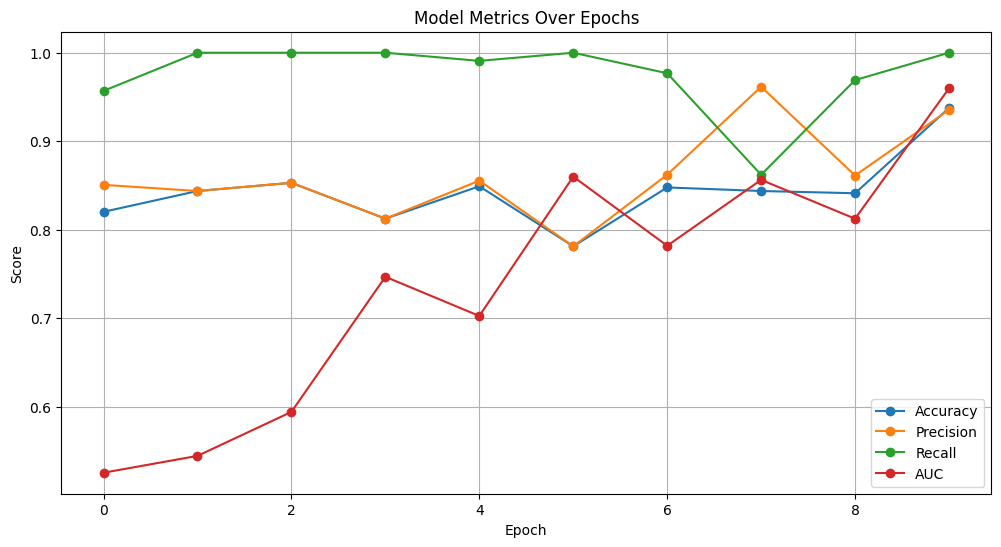

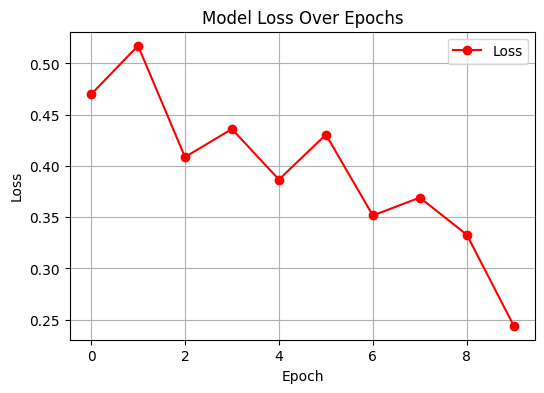

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy, precision, recall, and AUC
plt.figure(figsize=(12, 6))

# Accuracy
plt.plot(history.history['accuracy'], label='Accuracy', marker='o')

# Precision
plt.plot(history.history['precision'], label='Precision', marker='o')

# Recall
plt.plot(history.history['recall'], label='Recall', marker='o')

# AUC
plt.plot(history.history['auc'], label='AUC', marker='o')

plt.title('Model Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss', color='red', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step


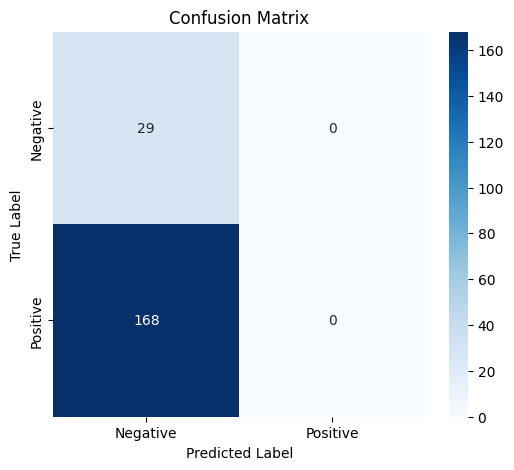

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get ground truth labels and predicted labels
val_labels = validation_generator.classes
val_preds = model.predict(validation_generator)
predicted_classes = np.argmax(val_preds, axis=1)

# Build confusion matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(val_labels, predicted_classes, target_names=list(validation_generator.class_indices.keys()))
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Negative       0.15      1.00      0.26        29
    Positive       0.00      0.00      0.00       168

    accuracy                           0.15       197
   macro avg       0.07      0.50      0.13       197
weighted avg       0.02      0.15      0.04       197



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8611 - auc: 0.7456 - loss: 0.5608 - precision: 0.8611 - recall: 1.0000 - val_accuracy: 0.7604 - val_auc: 0.9985 - val_loss: 0.7182 - val_precision: 0.7604 - val_recall: 1.0000
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8750 - auc: 0.8438 - loss: 0.5246 - precision: 0.8750 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8750 - auc: 0.8438 - loss: 0.5246 - precision: 0.8750 - recall: 1.0000 - val_accuracy: 0.7396 - val_auc: 0.9938 - val_loss: 0.9160 - val_precision: 0.7396 - val_recall: 1.0000
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8575 - auc: 0.8164 - loss: 0.5539 - precision: 0.8572 - recall: 1.0000 - val_accuracy: 0.7500 - val_auc: 0.9995 - val_loss: 0.6733 - val_precision: 0.7447 - val_recall: 1.0000
Epoch 4/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8438 - auc: 0.9185 - loss: 0.5041 - precision: 0.8438 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8438 - auc: 0.9185 - loss: 0.5041 - precision: 0.8438 - recall: 1.0000 - val_accuracy: 0.7604 - val_auc: 1.0000 - val_loss: 0.5515 - val_precision: 0.7579 - val_recall: 1.0000
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8747 - auc: 0.8601 - loss: 0.4939 - precision: 0.8732 - recall: 1.0000 - val_accuracy: 0.7292 - val_auc: 0.9989 - val_loss: 0.5766 - val_precision: 0.7263 - val_recall: 1.0000
Epoch 6/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.2972 - precision: 0.9688 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.2972 - precision: 0.9688 - recall: 1.0000 - val_accuracy: 0.7708 - val_auc: 0.9994 - val_loss: 0.4172 - val_precision: 0.7684 - val_recall: 1.0000
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8618 - auc: 0.8809 - loss: 0.4983 - precision: 0.8614 - recall: 0.9988 - val_accuracy: 0.7708 - val_auc: 1.0000 - val_loss: 0.5055 - val_precision: 0.7634 - val_recall: 1.0000
Epoch 8/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.1541 - precision: 0.9688 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.1541 - precision: 0.9688 - recall: 1.0000 - val_accuracy: 0.7292 - val_auc: 1.0000 - val_loss: 0.6260 - val_precision: 0.7204 - val_recall: 1.0000
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8762 - auc: 0.8806 - loss: 0.4546 - precision: 0.8729 - recall: 1.0000 - val_accuracy: 0.7500 - val_auc: 0.9942 - val_loss: 0.6823 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 10/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8438 - auc: 0.9778 - loss: 0.4171 - precision: 0.8438 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.8438 - auc: 0.9778 - loss: 0.4171 - precision: 0.8438 - recall: 1.0000 - val_accuracy: 0.7708 - val_auc: 0.9942 - val_loss: 0.7389 - val_precision: 0.7708 - val_recall: 1.0000


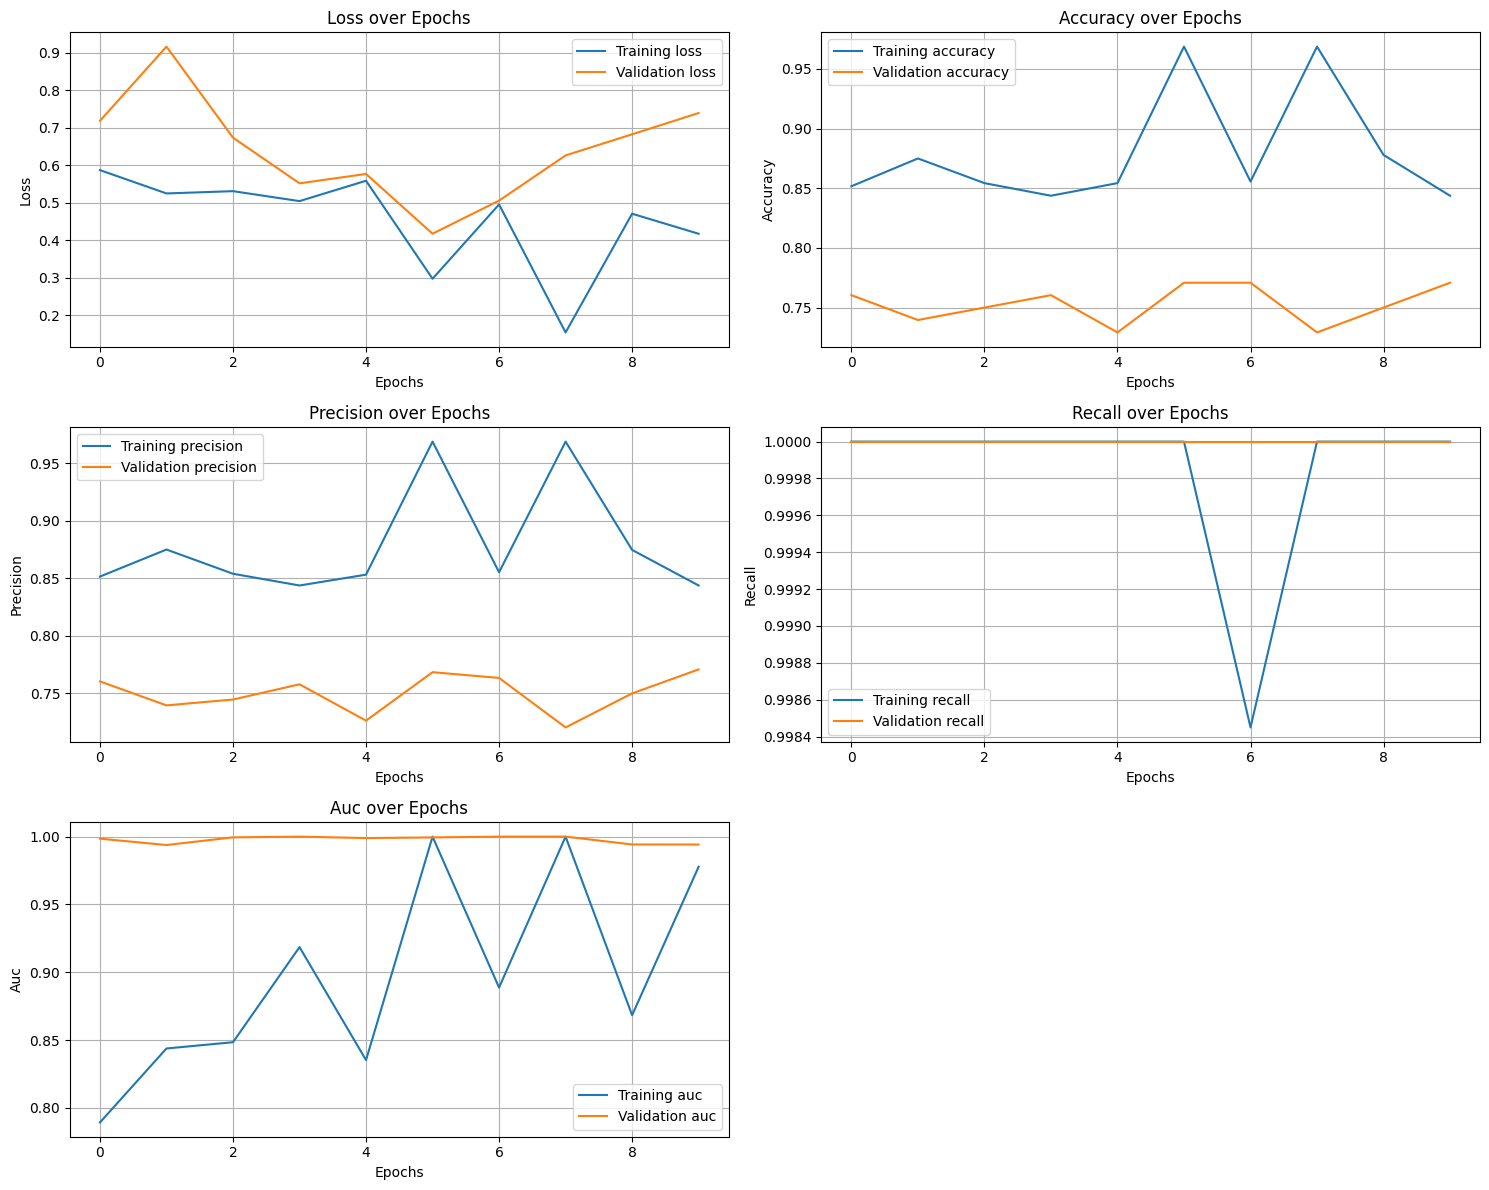

In [20]:
import matplotlib.pyplot as plt

# Extract values from history
history_dict = history.history

# Plot each metric
metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
val_metrics = ['val_' + m for m in metrics]

plt.figure(figsize=(15, 12))
for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i + 1)
    plt.plot(history.epoch, history_dict[metric], label=f'Training {metric}')
    plt.plot(history.epoch, history_dict['val_' + metric], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.title(f'{metric.capitalize()} over Epochs')

plt.tight_layout()
plt.show()


In [23]:
# Save your trained model
model.save("sickle_cell_classifier_final.keras")


In [24]:
from google.colab import files
files.download("sickle_cell_classifier_final.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# Load the saved model
model = load_model("sickle_cell_classifier_final.keras")

# Define the path to the dataset directory on Google Drive
dataset_dir = "/content/drive/MyDrive/SCD_Dataset/archive"

# Choose an example image path from the Negative class (assuming it exists)
img_path = os.path.join(dataset_dir, "Negative", "Clear", "5.jpg") # Updated image path

# Load and preprocess the test image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Make prediction
prediction = model.predict(img_array)
class_label = "Positive" if prediction[0][0] > 0.5 else "Negative"

print(f"Predicted Class: {class_label}")
print(f"Raw Prediction Score: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Class: Positive
Raw Prediction Score: 0.9152002334594727


In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("sickle_cell_classifier_final.keras")

# Directory containing test images (update this path if needed)
test_dir = "/content/drive/MyDrive/SCD_Dataset/cleaned_dataset/val/positive" # Updated path to your validation data

# Loop through and predict each image
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    try:
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        predicted_class = "Positive" if prediction[0][0] > 0.5 else "Negative"

        print(f"{img_name} ➤ Predicted: {predicted_class} (Score: {prediction[0][0]:.4f})")
    except Exception as e:
        print(f"Error with {img_name}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
178.jpg ➤ Predicted: Positive (Score: 0.9994)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
237.jpg ➤ Predicted: Positive (Score: 0.9997)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
80.jpg ➤ Predicted: Positive (Score: 0.9994)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
303.jpg ➤ Predicted: Positive (Score: 0.9998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
225.jpg ➤ Predicted: Positive (Score: 1.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
395.jpg ➤ Predicted: Positive (Score: 0.9995)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
328.jpg ➤ Predicted: Positive (Score: 1.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
135.jpg ➤ Predicted: Positive (Score: 0.9989)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
410.jpg ➤ Predicted: Positive (Score: 0.9952)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
351.jpg ➤ Predicted: Positive (Score: 1.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
218.jpg ➤ Predicted: Positive (Score: 0.9997)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2.jpg ➤ Predicted: Positive (Score: 0

In [31]:
# Load your trained model
model = load_model("sickle_cell_classifier_final.keras")

# Directory containing test images (update this path if needed)
test_dir = "/content/drive/MyDrive/SCD_Dataset/cleaned_dataset/val/negative" # Updated path to your validation data

# Loop through and predict each image
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    try:
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        predicted_class = "Negative" if prediction[0][0] > 0.5 else "Positive"

        print(f"{img_name} ➤ Predicted: {predicted_class} (Score: {prediction[0][0]:.4f})")
    except Exception as e:
        print(f"Error with {img_name}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
47.jpg ➤ Predicted: Negative (Score: 0.8515)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
13.jpg ➤ Predicted: Negative (Score: 0.9641)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
42.jpg ➤ Predicted: Negative (Score: 0.9111)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
69.jpg ➤ Predicted: Negative (Score: 0.9422)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
45.jpg ➤ Predicted: Negative (Score: 0.9036)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
25.jpg ➤ Predicted: Negative (Score: 0.7606)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
64.jpg ➤ Predicted: Negative (Score: 0.9431)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
78.jpg ➤ Predicted: Negative (Score: 0.9374)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
46.jpg ➤ Predicted: Negative (Score: 0.9032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
79.jpg ➤ Predicted: Negative (Score: 0.9740)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
19.jpg ➤ Predicted: Negative (Score: 0.9711)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
34.jpg ➤ Predicted: Negative (Score: 0.9823)

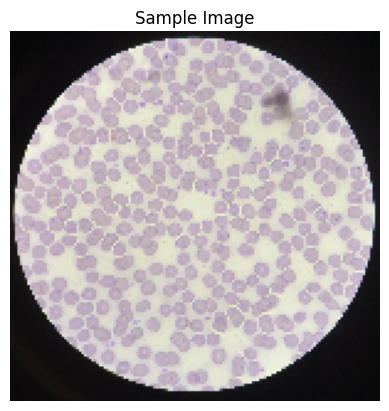

In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Image path
img_path = "/content/drive/MyDrive/SCD_Dataset/archive/Negative/Clear/55.jpg"

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0  # normalize
img_array = img_array.reshape((1, 150, 150, 3))  # batch dimension

# Display the image
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")
plt.show()


In [36]:
# Load your trained model
from tensorflow.keras.models import load_model

model = load_model("sickle_cell_classifier_final.keras")
# Predict
prediction = model.predict(img_array)

# Interpret the result
if prediction[0] > 0.5:
    print("🔴 Prediction: Positive (Sickle Cell Detected)")
else:
    print("🟢 Prediction: Negative (No Sickle Cell)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
🔴 Prediction: Positive (Sickle Cell Detected)


In [39]:
import pandas as pd

results = []

positive_folder = "/content/drive/MyDrive/SCD_Dataset/archive/Positive/Labelled"

for img_name in os.listdir(positive_folder)[:20]:  # You can increase the range
    img_path = os.path.join(positive_folder, img_name)

    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Positive (SCD)" if prediction[0][0] > 0.5 else "Negative (No SCD)"

    results.append({"Image": img_name, "Prediction": label})

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("positive_predictions.csv", index=False)
print("Saved to positive_predictions.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Saved to positive_predictions.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


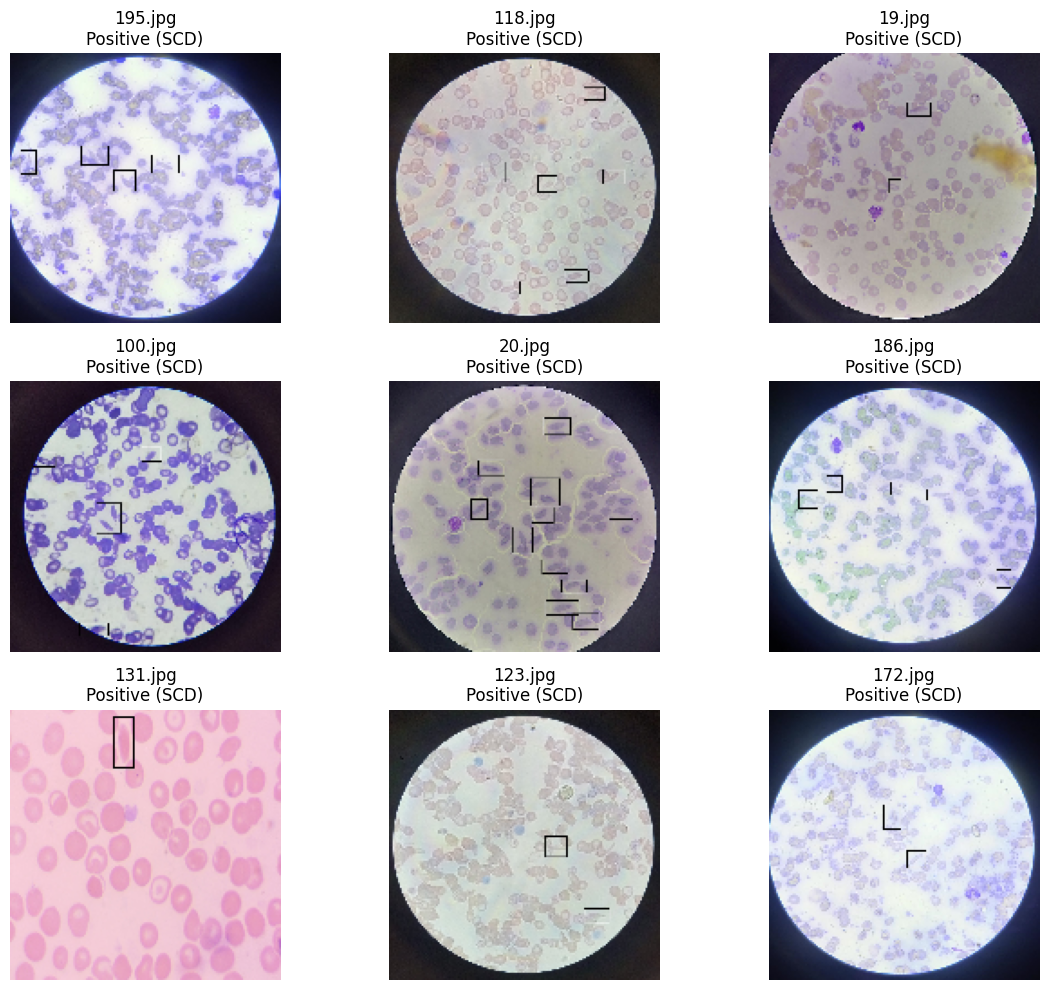

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

for i, img_name in enumerate(os.listdir(positive_folder)[:9]):
    img_path = os.path.join(positive_folder, img_name)
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Positive (SCD)" if prediction[0][0] > 0.5 else "Negative (No SCD)"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{img_name}\n{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [43]:
negative_folder = "/content/drive/MyDrive/SCD_Dataset/archive/Negative/Clear"
neg_results = []

for img_name in os.listdir(negative_folder)[:20]:  # Adjust number if needed
    img_path = os.path.join(negative_folder, img_name)

    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Positive (SCD)" if prediction[0][0] > 0.5 else "Negative (No SCD)"

    neg_results.append({"Image": img_name, "Prediction": label})

# Save to CSV
neg_df = pd.DataFrame(neg_results)
neg_df.to_csv("negative_predictions.csv", index=False)
print("Saved to negative_predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Saved to negative_predictions.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


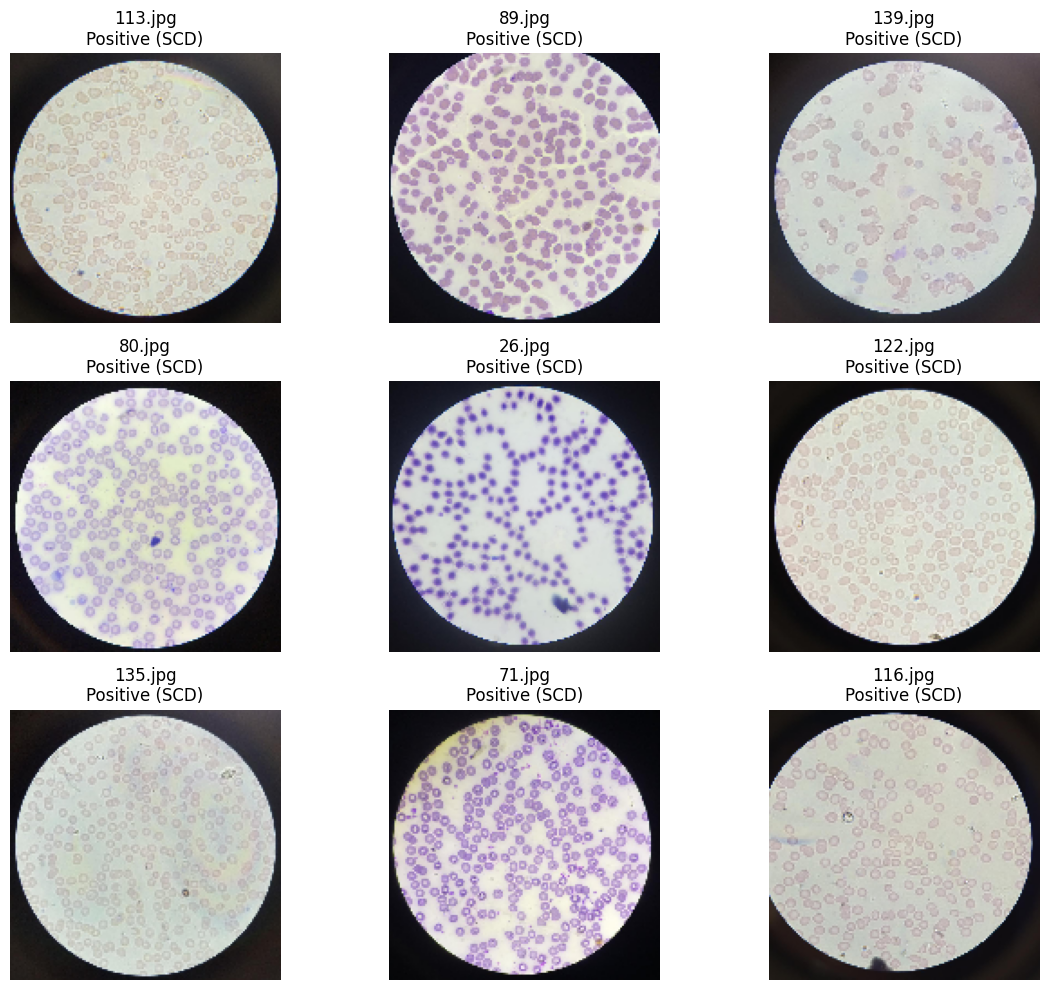

In [44]:
plt.figure(figsize=(12, 10))

for i, img_name in enumerate(os.listdir(negative_folder)[:9]):
    img_path = os.path.join(negative_folder, img_name)
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Positive (SCD)" if prediction[0][0] > 0.5 else "Negative (No SCD)"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{img_name}\n{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [45]:
score = prediction[0][0]
label = "Positive (SCD)" if score > 0.5 else "Negative (No SCD)"
print(f"{img_name}: {label} (Score: {score:.4f})")


116.jpg: Positive (SCD) (Score: 0.9474)


In [46]:
label = "Positive (SCD)" if prediction[0][0] > 0.7 else "Negative (No SCD)"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


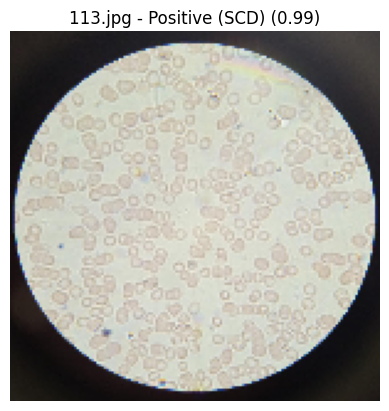

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


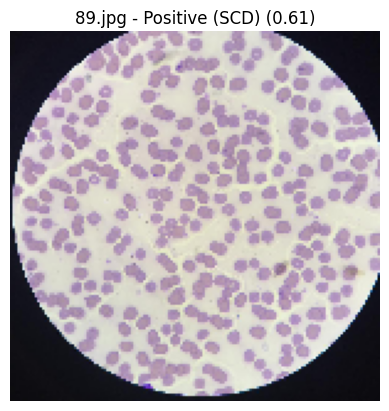

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


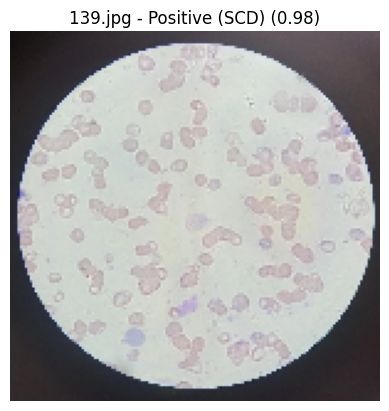

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


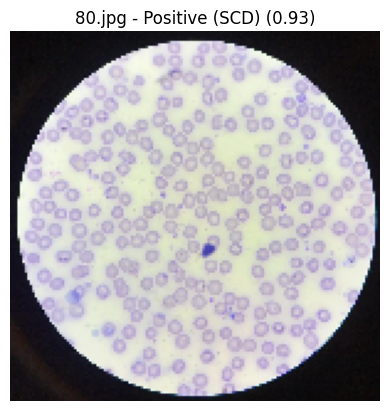

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


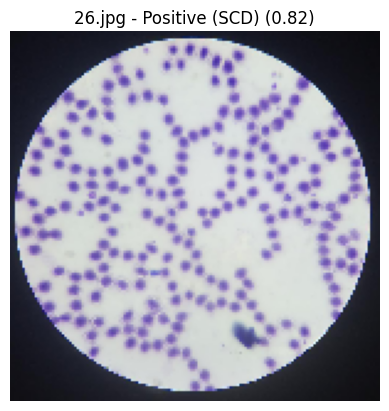

In [47]:
import matplotlib.pyplot as plt

for img_name in os.listdir(negative_folder)[:5]:
    img_path = os.path.join(negative_folder, img_name)
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Positive (SCD)" if prediction[0][0] > 0.5 else "Negative (No SCD)"

    plt.imshow(img)
    plt.title(f"{img_name} - {label} ({prediction[0][0]:.2f})")
    plt.axis('off')
    plt.show()


In [49]:
import os

train_dir = "/content/drive/MyDrive/SCD_Dataset/cleaned_dataset/train"  # Corrected path
print("Positive:", len(os.listdir(os.path.join(train_dir, "positive")))) # Corrected folder name
print("Negative:", len(os.listdir(os.path.join(train_dir, "negative")))) # Corrected folder name

Positive: 337
Negative: 117


In [51]:
from sklearn.utils import class_weight

# Calculate class weights based on the training data distribution
# Get the class indices from the training generator
class_indices = train_generator.class_indices
# Get the labels for the training data
train_labels = train_generator.classes
# Calculate the class weights
classes = np.unique(train_labels)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=classes,
    y=train_labels
)
class_weights = dict(zip(classes, class_weights_array))

print("Calculated Class Weights:", class_weights)

# Retrain the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights
)

Calculated Class Weights: {np.int32(0): np.float64(3.364406779661017), np.int32(1): np.float64(0.5872781065088757)}
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7501 - auc: 0.8089 - loss: 0.5893 - precision: 0.9366 - recall: 0.7604 - val_accuracy: 0.9531 - val_auc: 0.9966 - val_loss: 0.1235 - val_precision: 0.9477 - val_recall: 1.0000
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7812 - auc: 0.8429 - loss: 0.6803 - precision: 0.9130 - recall: 0.8077

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.7812 - auc: 0.8429 - loss: 0.6803 - precision: 0.9130 - recall: 0.8077 - val_accuracy: 0.9792 - val_auc: 0.9941 - val_loss: 0.1224 - val_precision: 0.9938 - val_recall: 0.9816
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6521 - auc: 0.8725 - loss: 0.4595 - precision: 0.9681 - recall: 0.6143 - val_accuracy: 0.9115 - val_auc: 0.9904 - val_loss: 0.1321 - val_precision: 0.9101 - val_recall: 0.9939
Epoch 4/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8750 - auc: 0.9792 - loss: 0.3417 - precision: 1.0000 - recall: 0.8333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8750 - auc: 0.9792 - loss: 0.3417 - precision: 1.0000 - recall: 0.8333 - val_accuracy: 0.9375 - val_auc: 0.9935 - val_loss: 0.1056 - val_precision: 0.9375 - val_recall: 0.9940
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7801 - auc: 0.9279 - loss: 0.3598 - precision: 0.9721 - recall: 0.7614 - val_accuracy: 0.9010 - val_auc: 0.9858 - val_loss: 0.1513 - val_precision: 0.9000 - val_recall: 0.9939
Epoch 6/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8750 - auc: 0.9310 - loss: 0.2696 - precision: 1.0000 - recall: 0.8621

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8750 - auc: 0.9310 - loss: 0.2696 - precision: 1.0000 - recall: 0.8621 - val_accuracy: 0.8958 - val_auc: 0.9845 - val_loss: 0.1451 - val_precision: 0.8994 - val_recall: 0.9877
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7368 - auc: 0.8762 - loss: 0.4574 - precision: 0.9536 - recall: 0.7221 - val_accuracy: 0.9583 - val_auc: 0.9903 - val_loss: 0.1141 - val_precision: 0.9588 - val_recall: 0.9939
Epoch 8/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6562 - auc: 0.9200 - loss: 0.4265 - precision: 1.0000 - recall: 0.5600

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.6562 - auc: 0.9200 - loss: 0.4265 - precision: 1.0000 - recall: 0.5600 - val_accuracy: 0.9635 - val_auc: 0.9913 - val_loss: 0.1092 - val_precision: 0.9645 - val_recall: 0.9939
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7570 - auc: 0.9299 - loss: 0.3412 - precision: 0.9835 - recall: 0.7297 - val_accuracy: 0.9010 - val_auc: 0.9751 - val_loss: 0.1757 - val_precision: 0.9016 - val_recall: 0.9940
Epoch 10/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7812 - auc: 0.9333 - loss: 0.3454 - precision: 0.9545 - recall: 0.7778

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.7812 - auc: 0.9333 - loss: 0.3454 - precision: 0.9545 - recall: 0.7778 - val_accuracy: 0.8854 - val_auc: 0.9815 - val_loss: 0.2134 - val_precision: 0.8817 - val_recall: 1.0000


In [52]:
import matplotlib.pyplot as plt

def predict_and_plot(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Positive (SCD)" if prediction > 0.5 else "Negative (No SCD)"

    plt.imshow(img)
    plt.title(f"Predicted: {label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


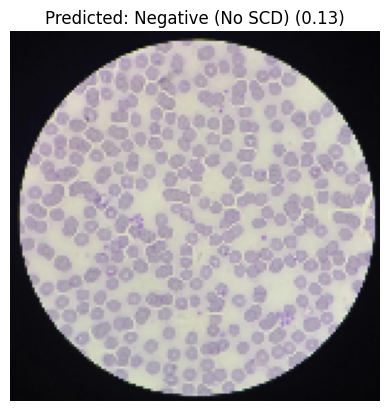

In [53]:
predict_and_plot("/content/drive/MyDrive/SCD_Dataset/archive/Negative/Clear/5.jpg")

In [54]:
model.save("sickle_cell_classifier_final.keras")


In [56]:
# Set path to test data
test_dir = "/content/drive/MyDrive/SCD_Dataset/cleaned_dataset/val"  # adjust if needed

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate model
loss, accuracy, auc, precision, recall = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Found 115 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.8954 - auc: 1.0000 - loss: 0.2458 - precision: 0.7607 - recall: 1.0000
Test Loss: 0.1433
Test Accuracy: 0.9391
Test AUC: 0.9239
Test Precision: 1.0000
Test Recall: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


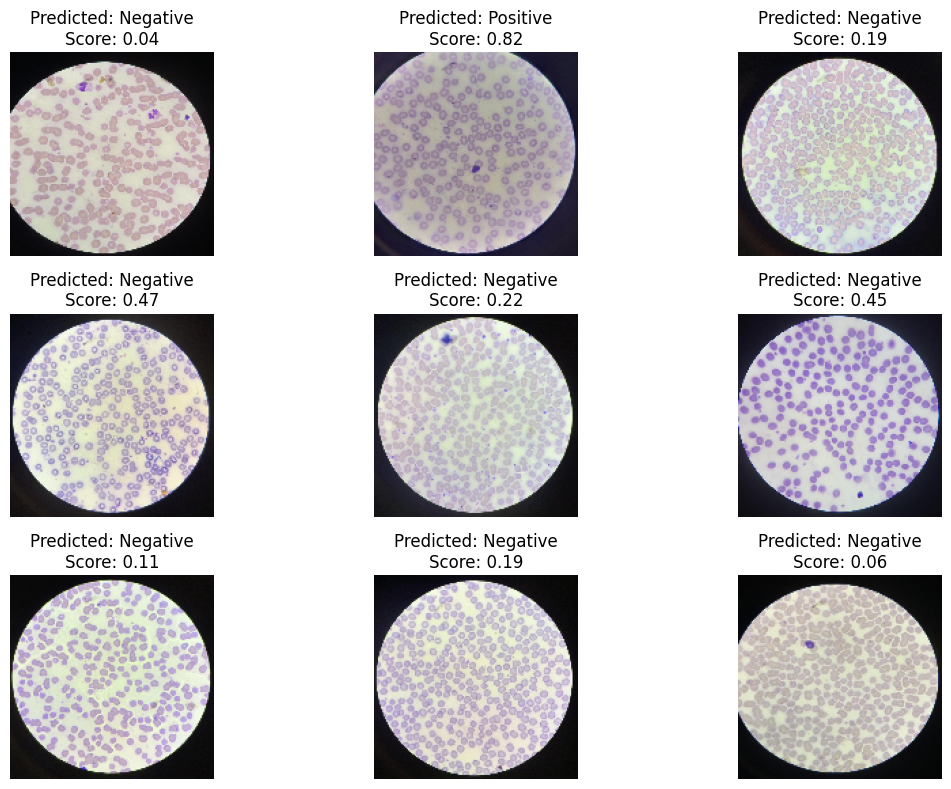

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Update path to your test folder
test_images_path = "/content/drive/MyDrive/SCD_Dataset/cleaned_dataset/val/negative"  # or Positive
image_files = os.listdir(test_images_path)[:9]  # Show first 9 images

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(test_images_path, img_name)
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Positive" if prediction > 0.5 else "Negative"

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {label}\nScore: {prediction:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [59]:
model.save("sickle_cell_classifier_final.keras")


In [63]:
from tensorflow.keras.models import load_model

model = load_model("sickle_cell_classifier_final.keras")